#### Import all required libraries

In [1]:
import cv2
import datetime
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage.measurements import label
from collections import deque
from glob import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from keras.models import Sequential, load_model
%matplotlib inline

from utils import color_utils, grad_utils, img_utils, lane_utils, car_utils
from utils.lane_utils import Line
from imageprocessor import ImageProcessor

from ipywidgets import widgets
from ipywidgets import interact

Using TensorFlow backend.


### Camera Calibration & Pre-processing

#### Let's start by calibrating the camera:

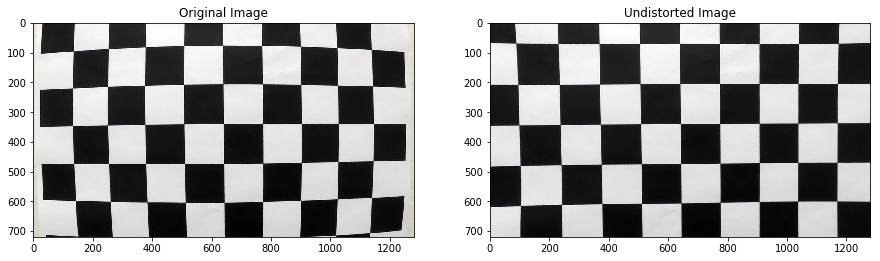

In [2]:
cal_images = glob('.\\cal_images\\calibration*.jpg')
#Chessboard Size
board_size = (9,6)
#Calibrate the camera
img_points, obj_points, mtx, dist = img_utils.cal_camera(cal_images, board_size)
#Test the undistortion
test_image = mpimg.imread('.\\cal_images\\test_image.jpg')
undist_img = img_utils.undistort(test_image, img_points, obj_points, mtx, dist)

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(test_image)
plt.title('Original Image')
plt.subplot(1,2,2)
plt.imshow(undist_img)
plt.title('Undistorted Image')
plt.show()

#### Now let's do a perspective transform to get a bird's eye view:

Image shape is: (720, 1280, 3)
Left line gradient:0.440
Right line gradient:0.440


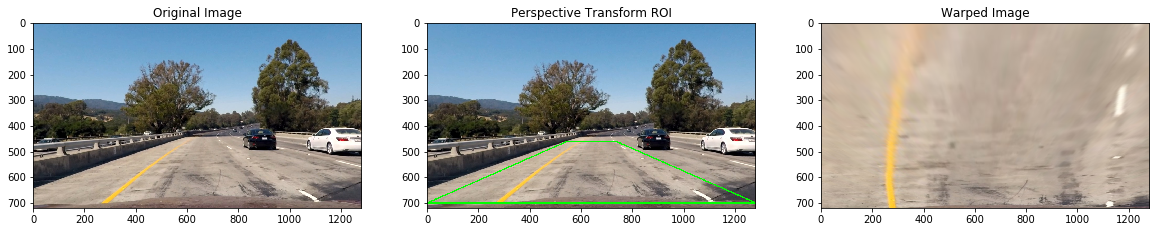

In [3]:
image = mpimg.imread('.\\test_images\\test1.jpg')
image = img_utils.undistort(image, img_points, obj_points, mtx, dist)

#'''
#Test Video ROI
y_top = 460
y_bottom = 700
xl_bottom = 0
xl_top = 545
xr_bottom = 1280
xr_top = 735
#'''

'''
#Challenge Video ROI
y_top = 480
y_bottom = 700
xl_bottom = 200
xl_top = 600
xr_bottom = 1100
xr_top = 750
'''

print("Image shape is:", image.shape)
src_points = np.float32([[xl_bottom, y_bottom], [xl_top, y_top], [xr_top, y_top], [xr_bottom, y_bottom]])
dst_points = np.float32([[xl_bottom,image.shape[0]], [xl_bottom, 0], 
                         [xr_bottom, 0], [xr_bottom, image.shape[0]]])
masked_image = np.copy(image)
img_utils.draw_ROI(masked_image, src_points)

print("Left line gradient:{:.3f}".format(np.abs((y_top-y_bottom)/(xl_top-xl_bottom))))
print("Right line gradient:{:.3f}".format(np.abs((y_bottom-y_top)/(xr_bottom-xr_top))))

warped_image = np.copy(image)
warped_image = img_utils.warp_image(warped_image, src_points, dst_points)

plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.imshow(image)
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(masked_image)
plt.title('Perspective Transform ROI')
plt.subplot(1,3,3)
plt.imshow(warped_image)
plt.title('Warped Image')
#plt.savefig('.\\output_images\\perspective_transform.jpg')
plt.show()

#### Determine thresholds for finding lane markings

In [ ]:
#Test LAB;B: [150,255] - Yellow Selector
#Test LAB; L: [215, 255] - White Selector
#Challenge LAB;B: [135,255] - Yellow Selector
#Challenge LAB; L: [190/205, 255] - White Selector
image = mpimg.imread('.\\test_images\\test7.jpg')

def f(x, y, a, b, c, d):
    A_binary = color_utils.LAB_threshold(image, 'A', (x,y))
    B_binary = color_utils.LAB_threshold(image, 'B', (a,b))
    L_binary = color_utils.LAB_threshold(image, 'L', (c,d))
    plt.figure(figsize = (20,10))
    plt.subplot(2,2,1)
    plt.imshow(image)
    plt.title("Original")
    plt.subplot(2,2,2)
    plt.imshow(L_binary, cmap = 'gray')
    plt.title("L Thresholded")
    plt.subplot(2,2,3)
    plt.imshow(B_binary, cmap = 'gray')
    plt.title("B Thresholded")
    plt.subplot(2,2,4)
    plt.imshow(A_binary, cmap = 'gray')
    plt.title("A Thresholded")

interact(f, x=widgets.IntSlider(min=0,max=255,step=1,value=126, continuous_update=False, description="Min A:"),
                   y=widgets.IntSlider(min=0,max=255,step=1,value=129, continuous_update=False, description="Max A:"), 
        a=widgets.IntSlider(min=0,max=255,step=1,value=150, continuous_update=False, description="Min B:"),
                   b=widgets.IntSlider(min=0,max=255,step=1,value=255, continuous_update=False, description="Max B:"),
        c=widgets.IntSlider(min=0,max=255,step=1,value=215, continuous_update=False, description="Min L:"),
                   d=widgets.IntSlider(min=0,max=255,step=1,value=255, continuous_update=False, description="Max L:"))

#### Let's take a look at the final image

In [ ]:
image = mpimg.imread('.\\test_images\\test4.jpg')
image = img_utils.undistort(image, img_points, obj_points, mtx, dist)

#'''
#Thresholds for test video
L_thresh = (215,255)
B_thresh = (150,255)
#'''

'''
#Thresholds for challenge video
L_thresh = (205,255)
B_thresh = (135,255)
'''

W_binary = color_utils.LAB_threshold(image, 'L', L_thresh)
Y_binary = color_utils.LAB_threshold(image, 'B', B_thresh) 
output = color_utils.OR_binaries(W_binary, Y_binary)

nrows, ncols = 2, 2
fig, axes = plt.subplots(nrows, ncols, figsize=(15,10))

plt.subplot(nrows,ncols,1)
plt.imshow(image)
plt.title('Original Image')
plt.subplot(nrows,ncols,2)
plt.imshow(output, cmap = 'gray')
plt.title('Combined Image')
plt.subplot(nrows,ncols,3)
plt.imshow(Y_binary, cmap = 'gray')
plt.title('L threshold')
plt.subplot(nrows,ncols,4)
plt.imshow(W_binary, cmap = 'gray')
plt.title('B threshold')


fig.tight_layout()
#plt.savefig('.\\output_images\\threshold_image.jpg')
plt.show()

### Instantiate the LeNet-5 model and process the video

In [ ]:
LeNet5 = load_model('.\\model\\LeNet5.h5')
#Initialize detector and set attributes
lenet_detector = ImageProcessor(img_points, obj_points, mtx, dist, src_points, dst_points)

#Variables for vehicle detection sliding windows
window_scale = (1.0, 1.5)
xy_window = (80, 80)
xy_overlap = (0.75, 0.75)

#'''
#Test video parameters
lenet_detector.L_thresh = (215,255)
lenet_detector.B_thresh = (150,255)
x_start_stop = [[575, 1280], [400, 1280]]
y_start_stop = [[375, 550], [450, 650]]
lenet_detector.pred_threshold = 0.75
lenet_detector.threshold = 11 #Use 1 for images 
lenet_detector.smooth_count = 15
#'''

'''
#Challenge video parameters
x_start_stop = [[650, 1280], [450, 1280]]
y_start_stop = [[425, 550], [500, 700]]    
lenet_detector.L_thresh = (205,255)
lenet_detector.B_thresh = (135,255)
lenet_detector.pred_threshold = 0.6 
lenet_detector.threshold = 7
lenet_detector.smooth_count = 10 
'''

#Common Parameters
lenet_detector.model = LeNet5
lenet_detector.window_scale = window_scale
lenet_detector.x_start_stop = x_start_stop
lenet_detector.y_start_stop = y_start_stop
lenet_detector.xy_overlap = xy_overlap
lenet_detector.xy_window = xy_window

In [ ]:
output_img = lenet_detector.lane_and_vehicle_detection_NN(image)
plt.imshow(output_img)
plt.show()

In [ ]:
project_output = 'test_videos_output\\challenge_output.mp4'
#clip1 = VideoFileClip("test_videos\\project_video.mp4").subclip(38,45)
clip1 = VideoFileClip(".\\test_videos\\challenge_video.mp4")
clip = clip1.fl_image(lenet_detector.lane_and_vehicle_detection)
%time clip.write_videofile(project_output, audio=False)
lenet_detector.log.close()

### Instantiate the Yolo model and process the video

In [4]:
yolo = load_model('.\\model\\PASCAL\\yolov2-voc.h5')
#Initialize detector and set attributes
yolo_detector = ImageProcessor(img_points, obj_points, mtx, dist, src_points, dst_points)
yolo_detector.model = yolo

#Test Video
yolo_detector.L_thresh = (215,255)
yolo_detector.B_thresh = (150,255)
#Challenge Video
#yolo_detector.L_thresh = (205,255)
#yolo_detector.B_thresh = (135,255)

yolo_detector.anchors_path = '.\\model\\PASCAL\\yolov2-voc_anchors.txt'
yolo_detector.class_path = '.\\model\\PASCAL\\pascal_classes.txt'

In [ ]:
yolo_img = yolo_detector.lane_and_vehicle_detection_YOLO(image)
plt.figure(figsize=(10,10))
plt.imshow(yolo_img)
plt.show()

In [5]:
project_output = 'test_videos_output\\test_output_YOLO.mp4'
#clip1 = VideoFileClip("test_videos\\project_video.mp4").subclip(38,45)
clip1 = VideoFileClip(".\\test_videos\\project_video.mp4")
clip = clip1.fl_image(yolo_detector.lane_and_vehicle_detection_YOLO)
%time clip.write_videofile(project_output, audio=False)
yolo_detector.log.close()

[MoviePy] >>>> Building video test_videos_output\test_output_YOLO.mp4
[MoviePy] Writing video test_videos_output\test_output_YOLO.mp4


100%|███████████████████████████████████████████████████████████████████████████▉| 1260/1261 [4:25:18<00:23, 23.55s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output\test_output_YOLO.mp4 

Wall time: 4h 25min 19s
